In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import chirp, spectrogram, convolve, find_peaks, savgol_filter
from scipy.io import wavfile
import sounddevice as sd
import subprocess

from utilities import *
from frft import *

In [2]:
# constellation_map = {
#     '00' : complex(1/np.sqrt(2), 1/np.sqrt(2)),
#     '01' : complex(-1/np.sqrt(2), 1/np.sqrt(2)),
#     '11' : complex(-1/np.sqrt(2), -1/np.sqrt(2)),
#     '10' : complex(1/np.sqrt(2), -1/np.sqrt(2)),
# }
constellation_map = {
    0: 1,
    1: -1,
}

QAM_symbols = np.array([*constellation_map.values()])
QAM_bits = np.array([*constellation_map.keys()])

In [3]:
N = 8192
L = 1024

np.random.seed(0)
source = np.random.choice(list(constellation_map.values()), (N-2)//2)
subcarrier_data = np.concatenate(([0], source, [0], np.conjugate(np.flip(source))))
x = np.fft.ifft(subcarrier_data).real
OFDM_symbol = np.concatenate((x[-L:], x))
OFDM_symbol /= np.max(np.abs(OFDM_symbol))

In [6]:
fs = 44100

t = np.linspace(0,1,fs)
chirp_standard = chirp(t, 1e3, 1, 10e3, method='linear')
f0 = 1000
K = 9000 # 9000 Hz/s
#chirp_standard = np.cos(2*np.pi*f0*t)*np.cos(np.pi*K*t**2)

pause = np.zeros(fs)

np.random.seed(1)
whitenoise = np.random.randn(fs)
whitenoise /= np.max(np.abs(whitenoise))

standard = np.concatenate([pause, chirp_standard, pause, whitenoise, pause])

OFDM_frame = np.tile(OFDM_symbol, 10)
signal = np.concatenate([standard, OFDM_frame])

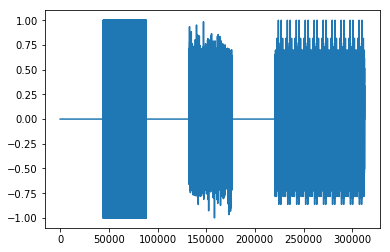

In [7]:
plt.plot(signal)

In [47]:
write('OFDM/test_frame.wav', fs, signal)

In [8]:
#subprocess.Popen(["afplay", "OFDM/test_frame.wav"])
#received = sd.rec(len(signal), samplerate = fs, channels = 1, blocking = True).flatten()
#write('OFDM/received_frame.wav', fs, received)

In [25]:
received = np.array(read('OFDM/received_frame.wav', fs)[1])

In [26]:
def synchronise(received, chirp_standard):
    conv = convolve(received, np.flip(chirp_standard), mode='same')
    return np.argmax(np.abs(conv))

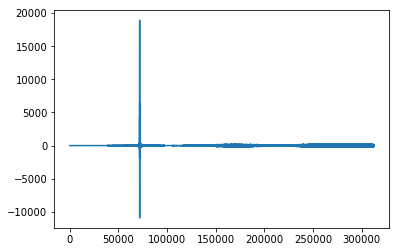

In [11]:
conv = convolve(received, np.flip(chirp_standard), mode='same')
plt.plot(conv)

In [29]:
windowed_chirp = np.hanning(len(chirp_standard))*chirp_standard

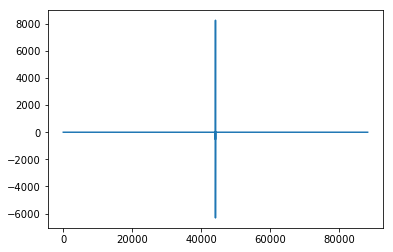

In [30]:
c = convolve(windowed_chirp, np.flip(windowed_chirp))
plt.plot(c)

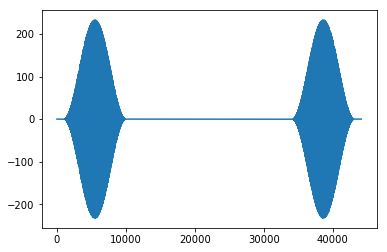

In [32]:
plt.plot(np.fft.fft(windowed_chirp))

In [12]:
%matplotlib qt
plt.plot(received)
start = synchronise(received, chirp_standard)
for i in range(-2,13):
    plt.axvline(x=start+i*fs//2, c='r')
plt.show()

In [13]:
fig = plt.figure(figsize=(17,5), dpi=150)
plt.rcParams.update({'font.size': 14})

plt.subplot(1,3,1)
plt.plot(signal)
plt.xlabel('Sample index')
plt.ylabel('Signal')
plt.title('Transmitted signal\n(chirp + whitenoise + OFDM frame)')
plt.locator_params(axis='x', nbins=4)

plt.subplot(1,3,2)
plt.plot(conv)
plt.xlabel('Sample index')
plt.title('Convolution of chirp\nwith inverse chirp')
plt.locator_params(axis='x', nbins=4)

plt.subplot(1,3,3)
plt.plot(received)
for i in range(-2,13):
    plt.axvline(x=start+i*fs//2, c='r')
plt.xlabel('Sample index')
plt.title('Received signal\nwith synchronisation from chirp')
plt.locator_params(axis='x', nbins=4)

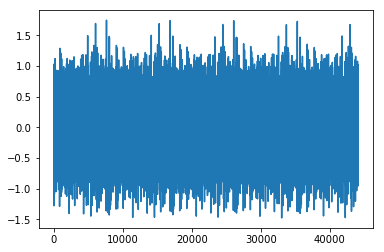

In [14]:
%matplotlib inline
received_frame = received[start+int(3.5*fs):start+int(4.5*fs)]
plt.plot(received_frame)

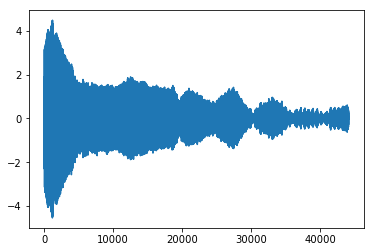

In [15]:
received_chirp = received[start-int(0.5*fs):start+int(0.5*fs)]
plt.plot(received_chirp)

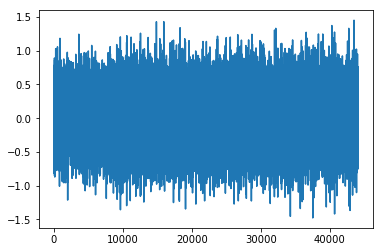

In [16]:
received_whitenoise = received[start+int(1.5*fs):start+int(2.5*fs)]
plt.plot(received_whitenoise)

## FrFT Channel estimation

In [17]:
res = optimise_a(chirp_standard)
res

     fun: -72.79829573355825
 message: 'Solution found.'
    nfev: 23
  status: 0
 success: True
       x: 0.8718468064328603

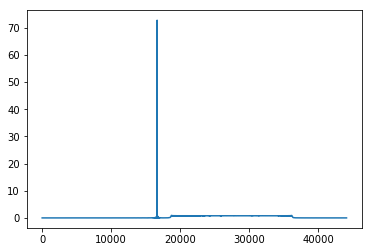

In [18]:
plt.plot(np.abs(frft(chirp_standard, res.x)))

In [19]:
def rejig(x):
    half = len(x) // 2
    return np.concatenate([np.flip(x[:half]), np.flip(x[half:])])

In [20]:
plt.plot(np.abs(frft2(chirp_standard[:1000], 1)))

NameError: name 'frft2' is not defined

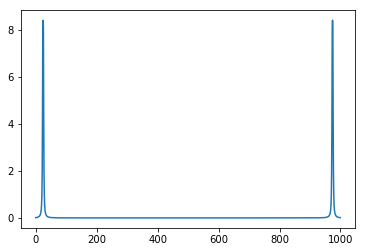

In [60]:
plt.plot(np.abs(rejig(frft(chirp_standard[:1000], 1))))

In [22]:
from scipy.linalg import dft

In [23]:
def frft2(x, alpha):
    N = len(x)
    C = np.power(dft(N), alpha)
    
    F = np.matmul(C, np.array([x]).T)
    
    return F

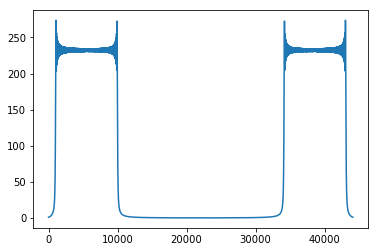

In [61]:
plt.plot(np.abs(np.fft.fft(chirp_standard)))

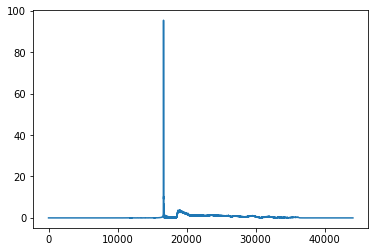

In [23]:
%matplotlib inline
Y_alpha_opt = frft(received_chirp, res.x)
plt.plot(np.abs(Y_alpha_opt))
#plt.yscale('log')

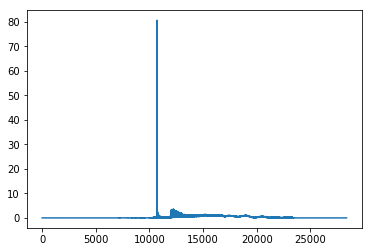

In [24]:
time_axes = np.arange(0,len(Y_alpha_opt), 1/np.cos(res.x))
frft_axes = np.arange(0,len(Y_alpha_opt))
Y_alpha_opt_t = np.interp(time_axes, frft_axes,Y_alpha_opt)
plt.plot(np.abs(Y_alpha_opt_t))

Text(0.5, 1.0, 'FrFT of received chirp\n(rescaled time axis)')

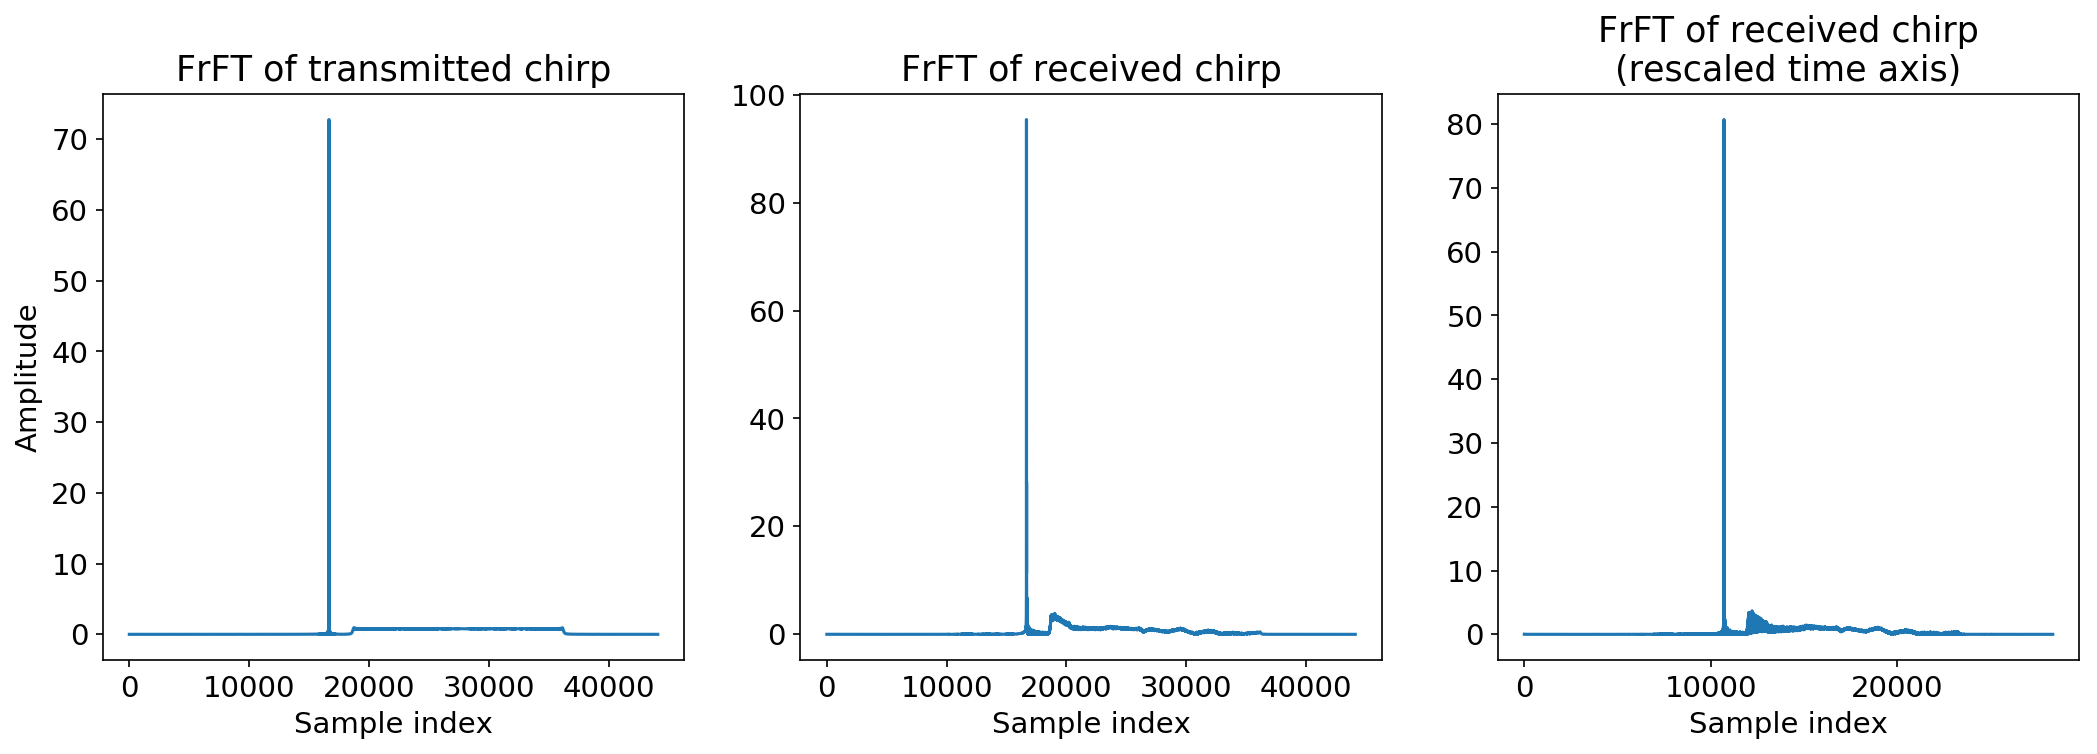

In [64]:
fig = plt.figure(figsize=(17,5), dpi=150)
plt.rcParams.update({'font.size': 14})

plt.subplot(1,3,1)
plt.plot(np.abs(frft(chirp_standard, res.x)))
plt.xlabel('Sample index')
plt.ylabel('Amplitude')
plt.title('FrFT of transmitted chirp')

plt.subplot(1,3,2)
plt.plot(np.abs(Y_alpha_opt))
plt.xlabel('Sample index')
plt.title('FrFT of received chirp')

plt.subplot(1,3,3)
plt.plot(np.abs(Y_alpha_opt_t))
plt.xlabel('Sample index')
plt.title('FrFT of received chirp\n(rescaled time axis)')

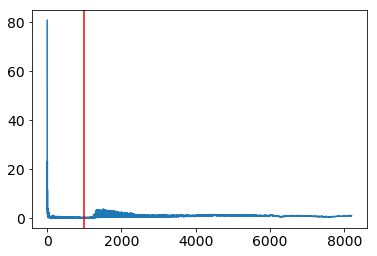

In [65]:
peak= np.argmax(Y_alpha_opt_t)
# h = np.zeros(N, dtype=complex)
# h[:1000] = Y_alpha_opt_t[peak:peak+1000]
h = Y_alpha_opt_t[peak:peak+N]
plt.plot(np.abs(h))
plt.axvline(1000, c='r')

In [66]:
1000/44100 * 330

7.482993197278912

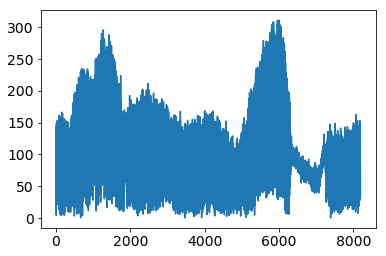

In [67]:
H = np.fft.fft(h)
plt.plot(np.abs(H))

/Users/matthewbarker/opt/anaconda3/envs/scienv/lib/python3.7/site-packages/ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


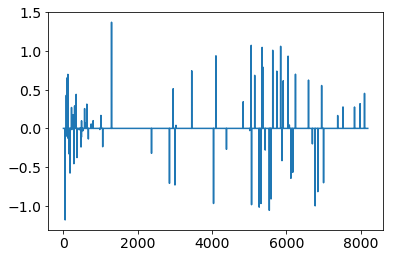

In [68]:
peaks, _ = find_peaks(np.abs(h), prominence=0.2, width=2)
h_smooth = np.zeros(len(h))
h_smooth[peaks] = h[peaks]
plt.plot(h_smooth)

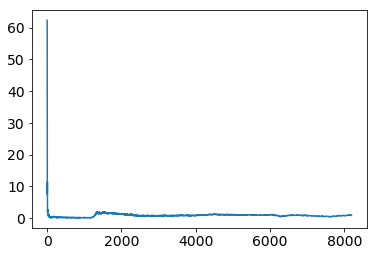

In [69]:
h_savgol = savgol_filter(abs(h), 11, 3) 
plt.plot(h_savgol)

/Users/matthewbarker/opt/anaconda3/envs/scienv/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


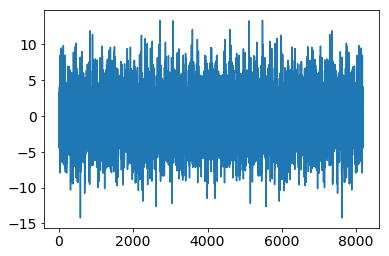

In [70]:
H_smooth = np.fft.fft(h_smooth)
plt.plot(H_smooth)

## White noise channel estimation

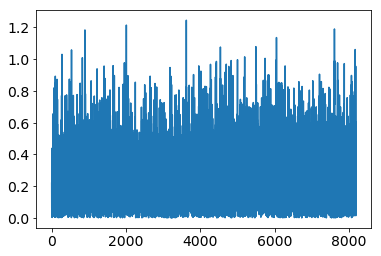

In [71]:
plt.plot(np.abs(received_whitenoise)[:N])
# plt.xscale('log')
# plt.yscale('log')

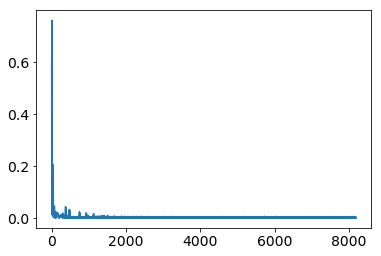

In [72]:
plt.plot(np.abs(np.fft.ifft(np.fft.fft(received_whitenoise)/np.fft.fft(whitenoise)))[:N])

## Decoding

In [73]:
received_frame

array([ 0.43503854,  0.46182752, -0.13072406, ..., -0.5615947 ,
       -0.03454576, -0.2797174 ], dtype=float32)

In [74]:
r = received_frame[L:(L+N)]

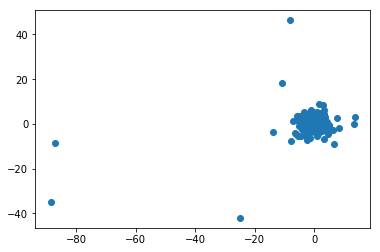

In [75]:
%matplotlib inline
R = np.fft.fft(r)
Xhat = R/H # deconvolution

plt.scatter(Xhat.real, Xhat.imag)

## Convolution channel estimation

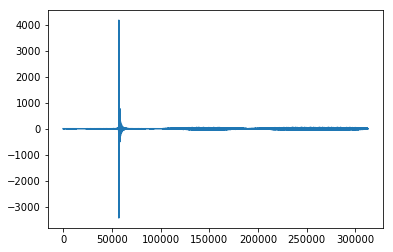

In [148]:
%matplotlib inline
conv = convolve(received, np.flip(chirp_standard), mode='same')
plt.plot(conv)

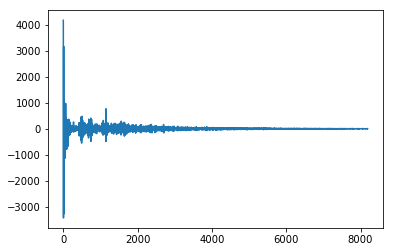

In [111]:
%matplotlib inline
impulse = conv[start:start+N]
plt.plot(conv[start:start+N])

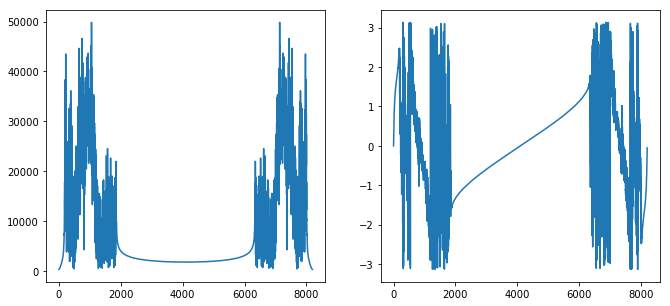

In [112]:
H = np.fft.fft(impulse)
plt.subplots(figsize=(11,5))
plt.subplot(1,2,1)
plt.plot(np.abs(H))
plt.subplot(1,2,2)
plt.plot(np.angle(H))

In [96]:
from scipy.signal import find_peaks

/Users/matthewbarker/opt/anaconda3/envs/scienv/lib/python3.7/site-packages/ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


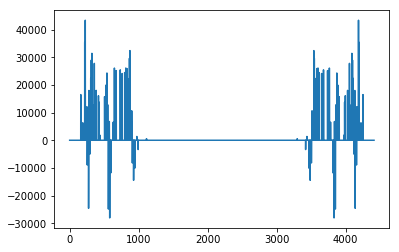

In [97]:
peaks, _ = find_peaks(np.abs(H), prominence=0.5, width=3)
H_smooth = np.zeros(len(H))
H_smooth[peaks] = H[peaks]
plt.plot(H_smooth)

Text(0.5, 1.0, 'Impulse response (chirp cross-correlation)')

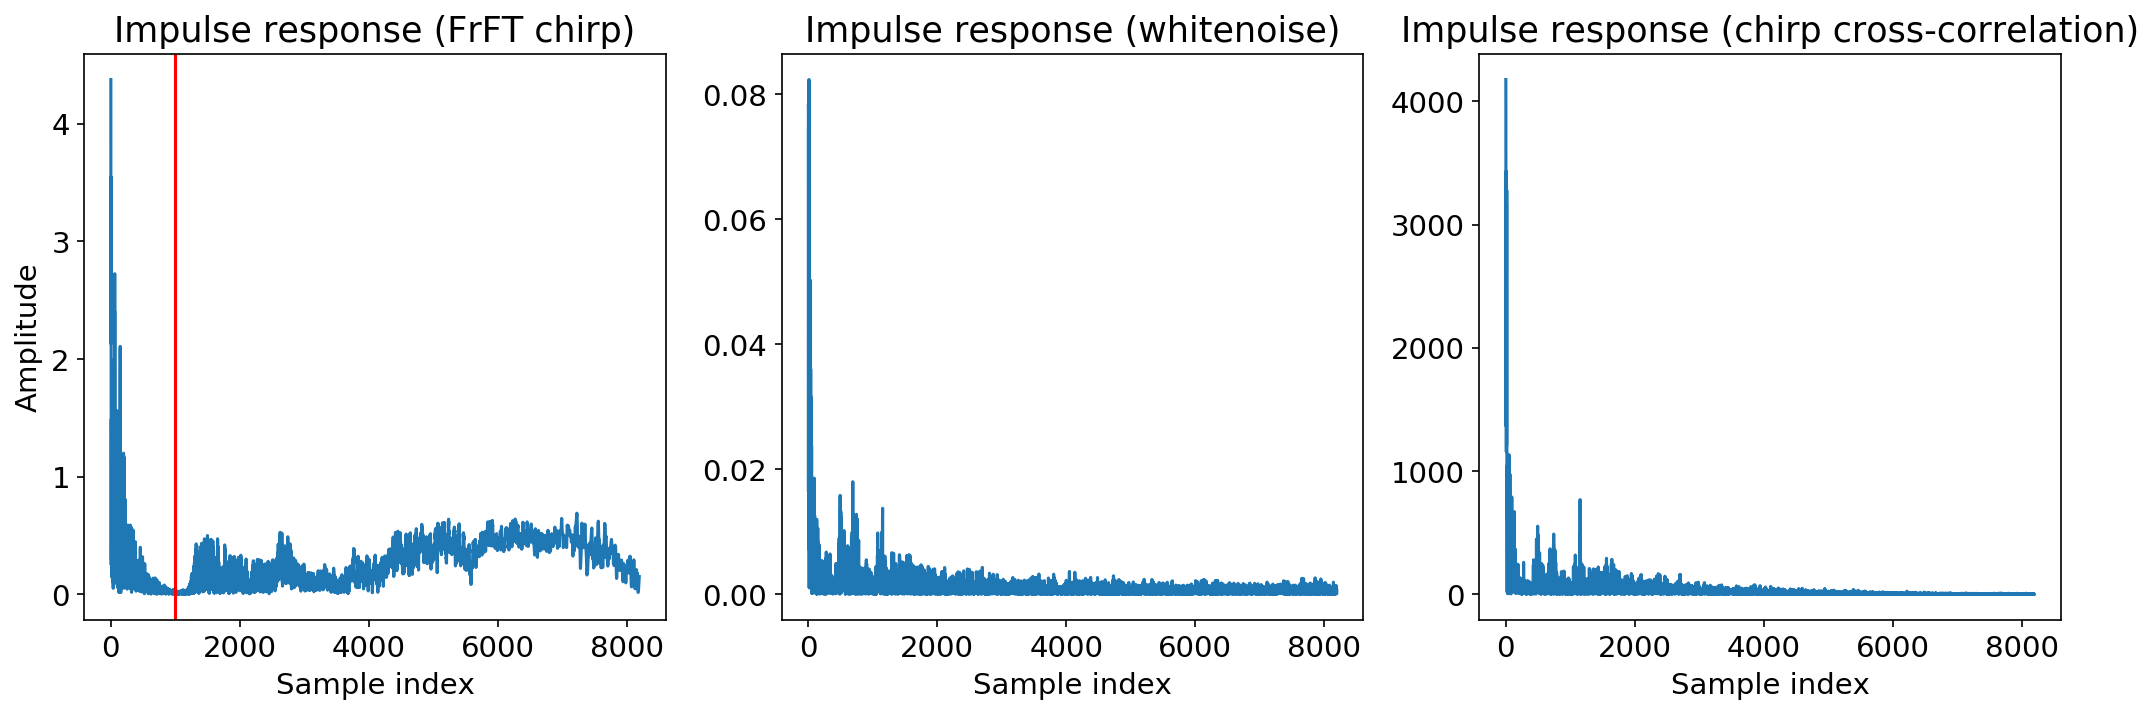

In [173]:
fig = plt.figure(figsize=(17,5), dpi=150)
plt.rcParams.update({'font.size': 14})

plt.subplot(1,3,1)
peak= np.argmax(Y_alpha_opt_t)
h = Y_alpha_opt_t[peak:peak+N]
plt.plot(np.abs(h))
plt.axvline(1000, c='r')
plt.xlabel('Sample index')
plt.ylabel('Amplitude')
plt.title('Impulse response (FrFT chirp)')

plt.subplot(1,3,2)
plt.plot(np.abs(np.fft.ifft(np.fft.fft(received_whitenoise)/np.fft.fft(whitenoise)))[:N])
plt.xlabel('Sample index')
plt.title('Impulse response (whitenoise)')

plt.subplot(1,3,3)
plt.plot(np.abs(conv[start:start+N]))
plt.xlabel('Sample index')
plt.title('Impulse response (chirp cross-correlation)')